In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from functions_SqRA import grid1, adjancency_matrix_sparse, build_sqra, build_sqra_i


np.random.seed(0) 

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu mol-1
gamma  = 1                           # ps-1 
D      = kB * T / mass / gamma       # nm2 ps-1
sigma  = np.sqrt(2 * D)              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

## Potential energy function

In [3]:
def V_i(x):
    return 1*(x**2 - 1) ** 2 

def V_ij(x,y):
    return 0.5*np.abs(x - y)**2

def V_I(N,X):
    
    v = 0
    
    for i in range(N-1):
        v = v + V_ij(X[i],X[i+1])
    return v

def V(N, c, X):
    
    v = 0
    
    for i in range(N):
        v = v + V_i(X[i])
        
        if i<N-1:
            v = v + c * V_ij(X[i],X[i+1])
            
    return v

## Grid definition

Total number of bins:  9765625


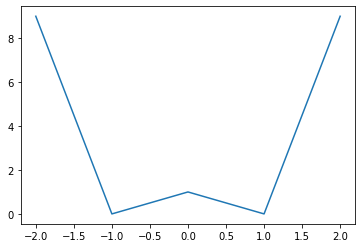

In [4]:
# Number of springs
Nd       = 10

Nedges = 6

a = 2.5
xcenters, xedges, xbins, dx = grid1(-a, a, Nedges)

bins = np.array([xbins for i in range(Nd)])
DX   = np.array([dx    for i in range(Nd)])

grid = np.meshgrid(*[xcenters for i in range(Nd)])
X    = np.stack([grid[i] for i in range(Nd)])

# Total number of bins
Nbins = xbins ** Nd
print("Total number of bins: ", Nbins)
plt.plot(xcenters, V_i(xcenters))

## Unperturbed system
#### Build matrix of each subsystem

In [5]:
# Stationary distribution
pi_i = np.exp(- beta * V_i(xcenters) ) 
PI = np.array([pi_i for i in range(Nd)]) #, dtype=object 

## SqRA
Q_i, Qo_i =  build_sqra_i(D, PI, DX, bins)

# Eigenvalue problem
evals_i = np.empty(Nd, dtype=object)

for i in range(Nd):
    evals_i[i],   _  =  scipy.sparse.linalg.eigs(Q_i[i],  2, which='LR')
    evals_i[i] = -np.sort(-evals_i[i])
    
# Create all combinations
evals = np.c_[np.array(np.meshgrid(*[evals_i[i] for i in range(Nd)])).T.reshape(-1,Nd)]

# Sum along the rows
evals = np.sum(evals, axis = 1)
        
# Sort eigenvalues
evals = -np.sort(-evals)
evals = evals[0:6]

In [ ]:
sqra_I = np.exp( - beta * V_I(Nd, X) / 2).reshape(bins)


    
def apply_qo_I_tensor(x):
    
    vec = x * sqra_I
    
    out = np.zeros(bins)

    for i in range(Nd):
        axes = [[1], [i]]
        td   = np.tensordot(Qo_i[i].toarray(), vec, axes=axes)

        for j in range(i):
            td = td.swapaxes(j,j+1)

        out = out + td
    
    return out / sqra_I

ones = np.ones(bins)
e    = apply_qo_I_tensor(ones)

def apply_q(x):
    
    Qx = apply_qo_I_tensor(x) - e * x
    return Qx

def apply_q_vec(xvec):
    xmat = np.reshape(xvec, bins)
    ymat = apply_q(xmat)
    yvec = ymat.flatten('C')
    return yvec

# Create the LinearOperator
linear_operator = scipy.sparse.linalg.LinearOperator((Nbins, Nbins), matvec=apply_q_vec)

# Compute eigenvalues and eigenvectors using eigs
evals_linO, _ = scipy.sparse.linalg.eigs(linear_operator, k=11, which='LR') #, ncv=50, maxiter= 1000
evals_linO = -np.sort(-evals_linO)

#plt.plot(evals_I,    's')
#plt.plot(evals_c1,   'o')
plt.plot(evals_linO, '.')

In [ ]:
evals_linO

In [ ]:
#np.savetxt('results/evals_Nd_'+str(Nd)+'.txt', np.real(evals_linO))

#np.savetxt('results/evecs_Nd_'+str(Nd)+'.txt', np.real(evecs_linO))

In [ ]:
e.shape
